In [ ]:
from tqdm import tqdm
import json
import pandas as pd

def read_data(path):
  sentence_a = []
  sentence_b = []
  labels = []
  with open(path, 'r', encoding='utf8') as f:
    for line in tqdm(f.readlines(), desc='Reading data'):
      line = json.loads(line)
      sentence_a.append(line['sentence1'])
      sentence_b.append(line['sentence2'])
      labels.append(int(line['label']))

  df = pd.DataFrame(zip(sentence_a,sentence_b,labels), columns=['text_a', 'text_b', 'labels'])
  return df

In [ ]:
train_df = read_data('/content/drive/MyDrive/train.json')

Reading data: 100%|██████████| 34334/34334 [00:00<00:00, 213443.66it/s]


In [ ]:
train_df.head()

,text_a,text_b,labels
0,蚂蚁借呗等额还款可以换成先息后本吗,借呗有先息到期还本吗,0
1,蚂蚁花呗说我违约一次,蚂蚁花呗违约行为是什么,0
2,帮我看一下本月花呗账单有没有结清,下月花呗账单,0
3,蚂蚁借呗多长时间综合评估一次,借呗得评估多久,0
4,我的花呗账单是***，还款怎么是***,我的花呗，月结出来说让我还***元，我自己算了一下详细名单我应该还***元,1


In [ ]:
dev_df = read_data('/content/drive/MyDrive/dev.json')

Reading data: 100%|██████████| 4316/4316 [00:00<00:00, 209160.31it/s]


In [ ]:
dev_df.head()

,text_a,text_b,labels
0,双十一花呗提额在哪,里可以提花呗额度,0
1,花呗支持高铁票支付吗,为什么友付宝不支持花呗付款,0
2,我的蚂蚁花呗支付金额怎么会有限制,我到支付宝实体店消费用花呗支付受金额限制,1
3,为什么有花呗额度不能分期付款,花呗分期额度不足,0
4,赠品不能设置用花呗付款,怎么不能花呗分期付款,0


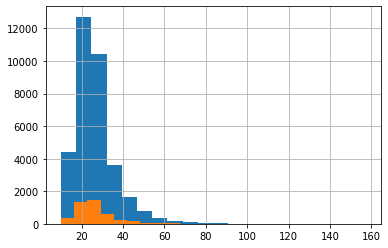

In [ ]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).hist(bins=20);
(dev_df.text_a.str.len() + dev_df.text_b.str.len()).hist(bins=20);

In [ ]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).quantile(0.99)

64.0

In [ ]:
import torch
import torch.nn as nn

config = {
    'train_file_path': '/content/drive/MyDrive/train.json',
    'dev_file_path': '/content/drive/MyDrive/dev.json',
    'test_file_path': '/content/drive/MyDrive/test.json',
    'emdedding_file_path': '/content/drive/MyDrive/sgns.weibo.word.bz2',
    'train_val_ratio': 0.1,
    'vocab_size': 30000,
    'batch_size': 64,
    'max_seq_len': 64,
    'num_epoches': 1,
    'learning_rate': 1e-3,
    'logging_step': 300,
    'seed': 2021
}

config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu' 

import random
import numpy as np

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed_everything(config['seed'])


In [ ]:
import jieba
from collections import Counter
def preprocess(config):
  def convert2df(file_path, dataset='train'):
    sentence_a = []
    sentence_b = []
    labels = []
    with open(file_path, 'r', encoding='utf8') as f:
      for line in tqdm(f.readlines(), desc=f'Reading {dataset} data'):
        line = json.loads(line)
        sentence_a.append(line['sentence1'])
        sentence_b.append(line['sentence2'])
        if dataset != 'test':
          labels.append(int(line['label']))
        else:
          labels.append(0)

        tokens = list(jieba.cut(sentence_a[-1])) + list(jieba.cut(sentence_b[-1]))
        token_counter.update(tokens)

    df = pd.DataFrame(zip(sentence_a, sentence_b, labels), columns=['text_a', 'text_b', 'lables'])
    return df
  
  token_counter = Counter()

  train_df = convert2df(config['train_file_path'], 'train')
  dev_df = convert2df(config['dev_file_path'], 'dev')
  test_df = convert2df(config['test_file_path'], 'test')

  train_df = train_df.append(dev_df)

  vocab = set(token for token,_ in token_counter.most_common(config['vocab_size']))
  return train_df, test_df, vocab


In [ ]:
train_df, test_df, vocab = preprocess(config)

Reading test data: 100%|██████████| 3861/3861 [00:00<00:00, 4026.75it/s]


In [ ]:
import bz2
def get_embedding(vocab):
  token2embedding = {}
  
  with bz2.open('/content/drive/MyDrive/sgns.weibo.word.bz2') as f:
    token_vector = f.readlines()

    meta_info = token_vector[0].split()
    print(f'{meta_info[0]} tokens in vectors file in total, vector size is {meta_info[1]}')

    for line in tqdm(token_vector[1:]):
      line = line.split()
      token = line[0].decode('utf8')
      vector = line[1:]

      if token in vocab:
        token2embedding[token] = [float(num) for num in vector] # 转换数据类型     

    token2id = {token: idx for idx, token in enumerate(token2embedding.keys(),4)}
    id2embedding = {token2id[token]: embedding for token, embedding in token2embedding.items()}

    PAD, UNK, BOS, EOS = '<pad>', '<unk>', '<bos>', '<eos>'
    token2id[PAD] = 0
    token2id[UNK] = 1
    token2id[BOS] = 2
    token2id[EOS] = 3

    id2embedding[0] = [.0] * int(meta_info[1])
    id2embedding[1] = [.0] * int(meta_info[1])
    id2embedding[2] = np.random.random(int(meta_info[1])).tolist()
    id2embedding[3] = np.random.random(int(meta_info[1])).tolist()

    emb_mat = [id2embedding[idx] for idx in range(len(id2embedding))] 

    return torch.tensor(emb_mat, dtype=torch.float), token2id, len(vocab)+4

In [ ]:
emb_mat, token2id, config['vocab_size'] = get_embedding(vocab)

b'195202' tokens in vectors file in total, vector size is b'300'


100%|██████████| 195202/195202 [00:03<00:00, 50461.23it/s]


In [ ]:
def tokenizer(sent, token2id):
  ids = [token2id.get(token,1) for token in jieba.cut(sent)]
  return ids

In [ ]:
import pandas as pd
from collections import defaultdict
def read_data(data_df, train_val_ratio, token2id, mode='train'):

  if mode == 'train':
    X_train, y_train = defaultdict(list), []
    X_val, y_val = defaultdict(list), []

    num_val = int(config['train_val_ratio'] * len(data_df))
  
  else:
    X_test, y_test = defaultdict(list), []

  for i, row in tqdm(data_df.iterrows(), desc=f'Preprocesing {mode} data', total=len(data_df)):
    # ---------------------------------------------#
    text_left = row[0]
    text_right = row[1]
    label = row[2]

    inputs_a = tokenizer(text_left, token2id)
    inputs_b = tokenizer(text_right, token2id)

    if mode == 'train':
      if i < num_val:
        X_val['text_left'].append(inputs_a)
        X_val['text_right'].append(inputs_b)
        y_val.append(label)
      else:
        X_train['text_left'].append(inputs_a)
        X_train['text_right'].append(inputs_b)
        y_train.append(label)

    else:
      X_test['text_left'].append(inputs_a)
      X_test['text_right'].append(inputs_b)
      y_test.append(label)
    # ---------------------------------------------#

  if mode == 'train':
    label2id = {label: i for i, label in enumerate(np.unique(y_train))}
    id2label = {i: label for label, i in label2id.items()}

    y_train = torch.tensor([label2id[label] for label in y_train], dtype=torch.long)
    y_val = torch.tensor([label2id[label] for label in y_val], dtype=torch.long)

    return X_train, y_train, X_val, y_val, label2id, id2label
  
  else:
    y_test = torch.tensor(y_test, dtype=torch.long)

    return X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], token2id, mode='train')
X_test, y_test = read_data(test_df, config['train_val_ratio'], token2id, mode='test')

Preprocesing test data: 100%|██████████| 3861/3861 [00:01<00:00, 3114.67it/s]


In [ ]:
from torch.utils.data import Dataset
class AFQMCDataset(Dataset):
  def __init__(self, X, y):
    super(AFQMCDataset, self).__init__()
    self.x = X
    self.y = y

  def __getitem__(self, idx):
    # ---------------------------------------------#
    data = (self.x['text_left'][idx], self.x['text_right'][idx], self.y[idx])
    return data
    # ---------------------------------------------#

  def __len__(self):
    return self.y.size(0)

In [ ]:
class Collator():
  def __init__(self, max_seq_len):
    self.max_seq_len = max_seq_len

  def get_max_seq_len(self, ids_list):
    cur_max_seq_len = max(len(input_id) for input_id in ids_list)
    max_seq_len = min(cur_max_seq_len, self.max_seq_len)
    return max_seq_len
  
  @staticmethod
  def pad_and_truncate(text_ids_list, max_seq_len):
    input_ids_tensor = torch.zeros((len(text_ids_list), max_seq_len), dtype=torch.long)
    
    for i, text_ids in enumerate(text_ids_list):
      seq_len = min(len(text_ids), max_seq_len)
      input_ids_tensor[i, :seq_len] = torch.tensor(text_ids[:seq_len], dtype=torch.long)

    return input_ids_tensor


  def __call__(self, examples):
    text_left_ids_list, text_right_ids_list, labels_list = list(zip(*examples))

    max_text_left_length = self.get_max_seq_len(text_left_ids_list)
    max_text_right_length = self.get_max_seq_len(text_right_ids_list)

    text_left_ids = self.pad_and_truncate(text_left_ids_list, max_text_left_length)
    text_right_ids = self.pad_and_truncate(text_right_ids_list, max_text_right_length)
    labels = torch.tensor(labels_list, dtype=torch.long)

    data_list = [text_left_ids, text_right_ids, labels]
    return data_list
                        

In [ ]:
import collections
from torch.utils.data import DataLoader
def build_dataloader(train_df, test_df, config, token2id):
  X_train, y_train, X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], token2id, mode='train')
  X_test, y_test = read_data(test_df, config['train_val_ratio'], token2id, mode='test')

  train_dataset = AFQMCDataset(X_train, y_train)
  val_dataset = AFQMCDataset(X_val, y_val)
  test_dataset = AFQMCDataset(X_test, y_test)

  # ---------------------------------------------#
  collate_fn = Collator(config['max_seq_len'])
  # ---------------------------------------------#

  train_dataloader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], num_workers=4, shuffle=True, collate_fn=collate_fn)
  val_dataloader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], num_workers=4, shuffle=False, collate_fn=collate_fn)
  test_dataloader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], num_workers=4, shuffle=False, collate_fn=collate_fn)

  return id2label, train_dataloader, val_dataloader, test_dataloader

In [ ]:
id2label, train_dataloader, val_dataloader, test_dataloader = build_dataloader(train_df, test_df, config, token2id)

Preprocesing test data: 100%|██████████| 3861/3861 [00:01<00:00, 3082.16it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for batch in train_dataloader:
  print(batch)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[tensor([[  16, 3195,   60,  ...,    0,    0,    0],
        [  22, 3584, 2095,  ...,    0,    0,    0],
        [  22,    5,  272,  ...,    0,    0,    0],
        ...,
        [ 272, 1359, 3507,  ...,    0,    0,    0],
        [  61, 2076, 1448,  ...,    0,    0,    0],
        [  22, 1448, 1359,  ...,    0,    0,    0]]), tensor([[ 272, 1359,   60,  ...,    0,    0,    0],
        [   1, 2947, 2036,  ...,    0,    0,    0],
        [ 272, 1359, 1313,  ...,    0,    0,    0],
        ...,
        [ 272, 1359,   22,  ...,    0,    0,    0],
        [ 108,  713,  111,  ...,    0,    0,    0],
        [ 803,   69, 4403,  ...,    0,    0,    0]]), tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])]


In [ ]:
from sklearn.metrics import f1_score,accuracy_score
def evaluation(model, config, val_dataloader):
  model.eval()
  preds = []
  labels = []
  val_loss = 0.
  val_iterator = tqdm(val_dataloader, desc='Evaluation', total=len(val_dataloader))

  with torch.no_grad():
    for batch in val_iterator:  
      # ---------------------------------------------#
      labels.append(batch[-1])
      batch = [item.to(config['device']) for item in batch]
      # ---------------------------------------------#

      loss, logits = model(batch)[:2]
      val_loss += loss.item()
      
      preds.append(logits.argmax(dim=-1).detach().cpu())

  avg_val_loss = val_loss/len(val_dataloader)
  labels = torch.cat(labels, dim=0).numpy()
  preds = torch.cat(preds, dim=0).numpy()

  f1 = f1_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)

  return avg_val_loss, f1, acc


In [ ]:
from torch.optim import AdamW
from tqdm import trange
def train(model, config, train_dataloader, val_dataloader):
  optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
  model.to(config['device'])
  epoches_iterator = trange(config['num_epoches'])

  global_steps = 0
  train_loss = 0.
  logging_loss = 0.

  for epoch in epoches_iterator:
    train_iterator = tqdm(train_dataloader, desc='Training', total=len(train_dataloader))
    model.train()
    
    for batch in train_iterator:
      # ---------------------------------------------#
      batch = [item.to(config['device']) for item in batch]
      loss = model(batch)[0]
      # ---------------------------------------------#

      model.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss
      global_steps +=1

      if global_steps % config['logging_step'] == 0:
        print_train_loss = (train_loss - logging_loss)/ config['logging_step'] 
        logging_loss = train_loss
        avg_val_loss, f1, acc = evaluation(model, config, val_dataloader)
        print(f'avg_val_loss:{avg_val_loss}, f1:{f1}, acc:{acc}')
        model.train()

  return model

In [ ]:
def predict(config, id2label, model, test_dataloader):
  model.eval()
  test_iterator = tqdm(test_dataloader, desc='Predicting', total=len(test_dataloader))
  test_preds =[]

  with torch.no_grad():
     for batch in test_iterator:
       # ---------------------------------------------#
       batch = [item.to(config['device']) for item in batch]
       logits = model(batch)[1]
       # ---------------------------------------------#
       test_preds.append(logits.argmax(dim=-1).detach().cpu())
  test_preds = torch.cat(test_preds, dim=0).numpy()
  test_preds = [id2label[idx] for idx in test_preds]

  test_df = pd.read_csv(config['test_file_path'], sep=',')
  test_df['preds'] = test_preds
  return test_df

In [ ]:
model_config = {
    'embedding': emb_mat,
    'freeze_emb': True,
    'hidden_size': 256,
    'dropout': 0.3,
    'num_layers': 2,
    'concat_layers': True,
    'rnn_type': 'lstm',
    'num_labels': len(id2label)
}

In [ ]:
class RNNDropout(nn.Dropout):
  # sequences_batch [B, L, D]
  def forward(self, sequences_batch):
    ones = sequences_batch.data.new_ones(sequences_batch.shape[0], sequences_batch.shape[-1])
    # 随机 mask ones
    dropout_mask = nn.functional.dropout(ones, self.p, self.training, inplace=False)

    return dropout_mask.unsqueeze(1) * sequences_batch

In [ ]:
import torch.nn.functional as F
class StackedBRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, 
               dropout_rate=0, dropout_output=False, rnn_type=nn.LSTM, concat_layers=False):
    super().__init__()
    self.dropout_output = dropout_output
    self.dropout_rate = dropout_rate
    self.num_layers = num_layers
    self.concat_layers = concat_layers
    self.rnns = nn.ModuleList()
    

    for i in range(num_layers):
      input_size = input_size if i ==0 else 2*hidden_size
      self.rnns.append(rnn_type(input_size, hidden_size, num_layers=1, bidirectional=True))

  def forward(self, x):
    # x [B, L, D] -->[L, B, D]
    x = x.transpose(0, 1)

    outputs = [x]

    for i in range(self.num_layers):
      rnn_input = outputs[-1]
      if self.dropout_rate > 0:
        rnn_input = F.dropout(rnn_input, p=self.drouput_rate, training=self.training)

      # self.rnn[i](rnn_input) : (output, (h_n, c_n))
      rnn_output = self.rnns[i](rnn_input)[0]
      outputs.append(rnn_output)


    # outputs [x, output0, output1]
    if self.concat_layers:
      output = torch.cat(outputs[1:],2)
    else:
      output = outputs[-1]
    
    # output [L, B, D] --> [B, L, D]
    output = output.transpose(0,1)

    if self.dropout_output and self.dropout_rate > 0:
      output = F.dropout(output, p=self.dropout_rate, training=self.training)

    return output.contiguous()

In [ ]:
class BidirectionalAttention(nn.Module):
  def __init__(self):
    super().__init__()

    # v1 [B, L, H]
    # v1_mask [B, L]
    # v2 [B, R, H]
    # v2_mask [B, R]
    
  def forward(self, v1, v1_mask, v2, v2_mask):
    # v1:b, v2:a
    # similarity_matrix [B, L, R]
    similarity_matrix = v1.bmm(v2.transpose(2, 1).contiguous())
    # v2_v1_attn [B, L, R]
    # v1_v2_attn [B, L, R]
    v2_v1_attn = F.softmax(similarity_matrix.masked_fill(v1_mask.unsqueeze(2), -1e7), dim=1)
    v1_v2_attn = F.softmax(similarity_matrix.masked_fill(v2_mask.unsqueeze(1), -1e7), dim=2)

    # attented_v1 [B, L, R]@[B, R, H] ->[B, L, H]
    attented_v1 = v1_v2_attn.bmm(v2)
    # v2_v1_attn [B, L, R] ->[B, R, L]@[B, L, H] ->[B, R, H]
    attented_v2 = v2_v1_attn.transpose(1,2).bmm(v1)

    attented_v1.masked_fill(v1_mask.unsqueeze(2), 0)
    attented_v2.masked_fill(v2_mask.unsqueeze(2), 0)
    return attented_v1, attented_v2


In [ ]:
class ESIM(nn.Module):

  def __init__(self, config):
    super().__init__()
    # ------------------------- input encoding -------------------------#
    rnn_mapping = {'lstm': nn.LSTM, 'gru': nn.GRU}
    self.embedding = nn.Embedding.from_pretrained(config['embedding'], freeze=config['freeze_emb'])

    self.rnn_dropout = RNNDropout(p=config['dropout'])
    rnn_size = config['hidden_size']

    if config['concat_layers']:
      rnn_size //=config['num_layers']

    self.input_encoding = StackedBRNN(input_size=config['embedding'].size(1),
                                      hidden_size=rnn_size//2,
                                      num_layers=config['num_layers'],
                                      rnn_type=rnn_mapping[config['rnn_type']],
                                      concat_layers=config['concat_layers'])
    # ------------------------- input encoding -------------------------#


    # ------------------------- local inference collected over sequences -------------------------#
    self.attention = BidirectionalAttention()
    # ------------------------- local inference collected over sequences -------------------------#

    # ------------------------- the composition layer -------------------------#
    self.projection = nn.Sequential(
        nn.Linear(4 * config['hidden_size'], config['hidden_size']),
        nn.ReLU()
    )

    self.composition = StackedBRNN(input_size=config['hidden_size'],
                                   hidden_size=rnn_size//2,
                                   num_layers=config['num_layers'],
                                   rnn_type=rnn_mapping[config['rnn_type']],
                                   concat_layers=config['concat_layers'])
    # ------------------------- the composition layer -------------------------#


    self.classification = nn.Sequential(
        nn.Dropout(p=config['dropout']),
        nn.Linear(4 * config['hidden_size'], config['hidden_size']),
        nn.Tanh(),
        nn.Dropout(p=config['dropout'])
    )

    self.out = nn.Linear(config['hidden_size'], config['num_labels'])

  def forward(self, inputs):
    # ------------------------- input encoding -------------------------#
    # query [B, L]
    # doc [B, R]
    query, doc = inputs[0].long(), inputs[1].long()

    # query_mask [B, L]
    # doc_mask [B, R]
    # 将 pad 的部分标注为1
    query_mask = (query == 0)
    doc_mask = (doc == 0)

    # query [B, L, D]
    # doc [B, R, D]
    query = self.embedding(query)
    doc = self.embedding(doc)
    
    # query [B, L, D]
    # doc [B, R, D]
    query = self.rnn_dropout(query)
    doc = self.rnn_dropout(doc)
    
    # query [B, L, H]
    # doc [B, R, H]
    query = self.input_encoding(query)
    doc = self.input_encoding(doc)
    # ------------------------- input encoding -------------------------#

    # ------------------------- local inference collected over sequences -------------------------#
    attened_query, attened_doc = self.attention(query, query_mask, doc, doc_mask)
    # ------------------------- local inference collected over sequences -------------------------#


    # ------------------------- enchancement of local inference information -------------------------#
    # enchanced_query [B, L, 4*h]
    # enchanced_doc [B, R, 4*h]
    enchanced_query = torch.cat([query, attened_query, query - attened_query, query * attened_query], dim=-1)
    enchanced_doc = torch.cat([doc, attened_doc, doc - attened_doc, doc * attened_doc], dim=-1)
    # ------------------------- enchancement of local inference information -------------------------#

    # ------------------------- the composition layer -------------------------#
    # projected_query [B, L, H]
    # projected_doc [B, R, H]
    projected_query = self.projection(enchanced_query)
    projected_doc = self.projection(enchanced_doc)

    query = self.composition(projected_query)
    doc = self.composition(projected_doc)
    # ------------------------- the composition layer -------------------------#

    # ------------------------- pooling -------------------------#    
    # reverse_query_mask [B, L]
    # reverse_doc_mask [B, R]
    reverse_query_mask = 1. - query_mask.float()
    reverse_doc_mask = 1. - doc_mask.float()

    query_avg = torch.sum(query*reverse_query_mask.unsqueeze(2), dim=1)/ (torch.sum(reverse_query_mask, dim=1, keepdim=True) + 1e-8)
    doc_avg = torch.sum(doc*reverse_doc_mask.unsqueeze(2), dim=1)/ (torch.sum(reverse_doc_mask, dim=1, keepdim=True) + 1e-8)
    
    # 确保max pooling时不会取到pad值
    query = query.masked_fill(query_mask.unsqueeze(2), -1e7)
    doc = doc.masked_fill(doc_mask.unsqueeze(2), -1e7)

    query_max, _ = query.max(dim=1)
    doc_max, _ = doc.max(dim=1)

    # v [B, 4*H]
    v = torch.cat([query_avg, query_max, doc_avg, doc_max], dim=-1)
    # ------------------------- pooling -------------------------#  

    # ------------------------- prediction -------------------------#  
    # hidden [B, H]
    hidden = self.classification(v)
    out = self.out(hidden)
    outputs = (out,)
    # ------------------------- prediction -------------------------#     

    if len(inputs) == 3:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(out, inputs[-1])
      outputs = (loss, ) + outputs

    return outputs



In [ ]:
model = ESIM(model_config)

In [ ]:
best_model = train(model, config, train_dataloader, val_dataloader)

Training:   0%|          | 0/484 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

Training:  62%|██████▏   | 299/484 [02:47<01:48,  1.70it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluation:   1%|          | 1/121 [00:00<01:05,  1.83it/s]

Evaluation:   2%|▏         | 2/121 [00:00<00:41,  2.88it/s]

Evaluation:   2%|▏         | 3/121 [00:01<00:36,  3.19it/s]

Evaluation:   3%|▎         | 4/121 [00:01<00:32,  3.61it/s]

Evaluation:   4%|▍         | 5/121 [00:01<00:38,  3.03it/s]

Evaluation:   5%|▍         | 6/121 [00:01<00:36,  3.18it/s]

Evaluation:   

0.6384318919221231 0.39919166796207056



100%|██████████| 1/1 [04:51<00:00, 291.63s/it]
